In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 1 1 0 0 1]


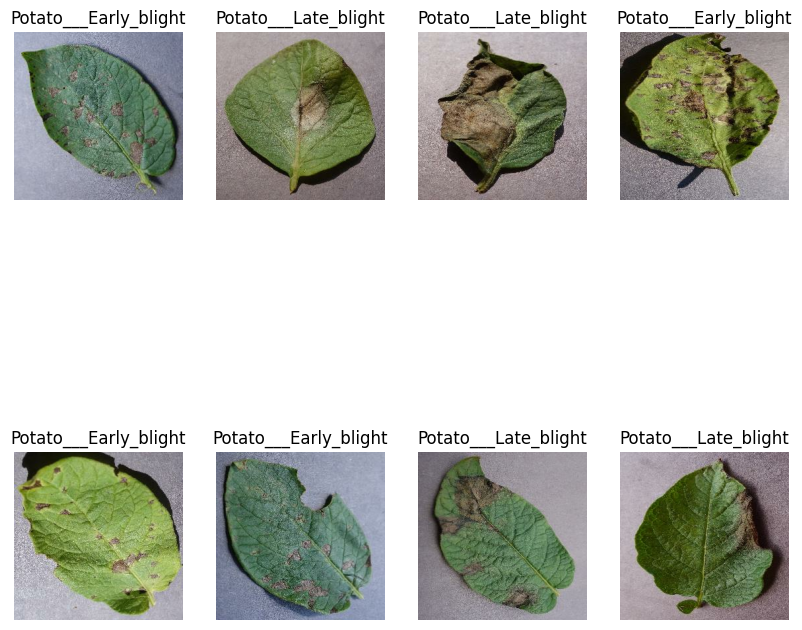

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
from tensorflow.keras.applications import InceptionV3

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                      

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 150s 392ms/step - loss: 0.5067 - accuracy: 0.8046 - val_loss: 0.2160 - val_accuracy: 0.9189
Epoch 2/50
300/300 [==============================] - 51s 165ms/step - loss: 0.2899 - accuracy: 0.8892 - val_loss: 0.1671 - val_accuracy: 0.9392
Epoch 3/50
300/300 [==============================] - 49s 162ms/step - loss: 0.2454 - accuracy: 0.9029 - val_loss: 0.1802 - val_accuracy: 0.9291
Epoch 4/50
300/300 [==============================] - 50s 168ms/step - loss: 0.2593 - accuracy: 0.9013 - val_loss: 0.2402 - val_accuracy: 0.8851
Epoch 5/50
300/300 [==============================] - 49s 162ms/step - loss: 0.2136 - accuracy: 0.9158 - val_loss: 0.4718 - val_accuracy: 0.8108
Epoch 6/50
300/300 [==============================] - 49s 162ms/step - loss: 0.1904 - accuracy: 0.9246 - val_loss: 0.1849 - val_accuracy: 0.9324
Epoch 7/50
300/300 [==============================] - 49s 164ms/step - loss: 0.1977 - accuracy: 0.9296 - val_loss: 0.1474 - val_a

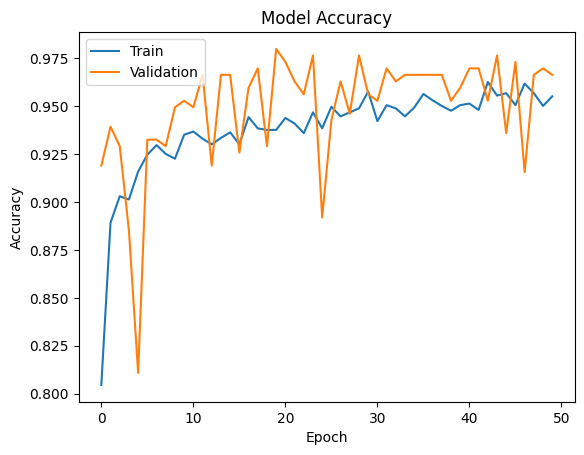

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

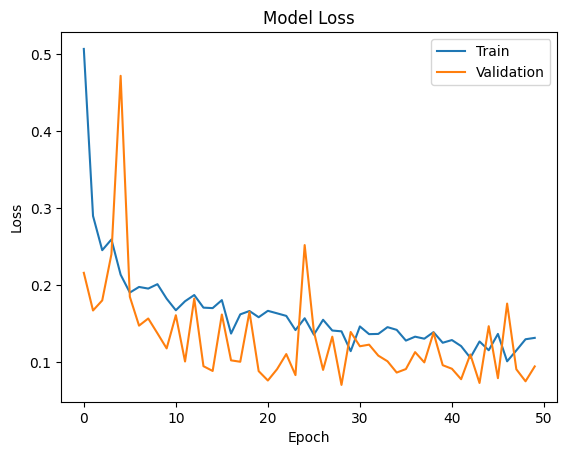

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

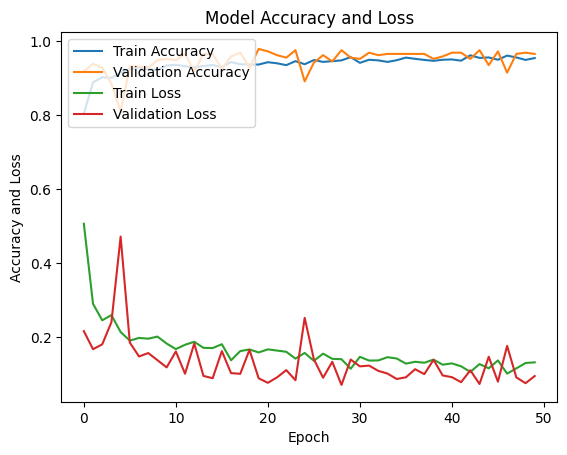

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 47s 92ms/step - loss: 0.1146 - accuracy: 0.9638


[0.8045833110809326,
 0.8891666531562805,
 0.902916669845581,
 0.9012500047683716,
 0.9158333539962769,
 0.9245833158493042,
 0.9295833110809326,
 0.925000011920929,
 0.9225000143051147,
 0.9350000023841858,
 0.9366666674613953,
 0.9329166412353516,
 0.9300000071525574,
 0.9333333373069763,
 0.9362499713897705,
 0.9300000071525574,
 0.9441666603088379,
 0.9383333325386047,
 0.9375,
 0.9375,
 0.9437500238418579,
 0.940833330154419,
 0.9358333349227905,
 0.9466666579246521,
 0.9383333325386047,
 0.9495833516120911,
 0.9445833563804626,
 0.9466666579246521,
 0.9487500190734863,
 0.9574999809265137,
 0.9420833587646484,
 0.9504166841506958,
 0.9487500190734863,
 0.9445833563804626,
 0.9491666555404663,
 0.956250011920929,
 0.95291668176651,
 0.949999988079071,
 0.9474999904632568,
 0.9504166841506958,
 0.9512500166893005,
 0.9479166865348816,
 0.9624999761581421,
 0.9554166793823242,
 0.9566666483879089,
 0.9504166841506958,
 0.9616666436195374,
 0.9566666483879089,
 0.949999988079071,
 0.

In [ ]:
history.history['val_accuracy']

[0.9189189076423645,
 0.9391891956329346,
 0.9290540814399719,
 0.8851351141929626,
 0.8108108043670654,
 0.9324324131011963,
 0.9324324131011963,
 0.9290540814399719,
 0.9493243098258972,
 0.9527027010917664,
 0.9493243098258972,
 0.9662162065505981,
 0.9189189076423645,
 0.9662162065505981,
 0.9662162065505981,
 0.9256756901741028,
 0.9594594836235046,
 0.9695945978164673,
 0.9290540814399719,
 0.9797297120094299,
 0.9729729890823364,
 0.962837815284729,
 0.9560810923576355,
 0.9763513803482056,
 0.8918918967247009,
 0.9425675868988037,
 0.962837815284729,
 0.9459459185600281,
 0.9763513803482056,
 0.9560810923576355,
 0.9527027010917664,
 0.9695945978164673,
 0.962837815284729,
 0.9662162065505981,
 0.9662162065505981,
 0.9662162065505981,
 0.9662162065505981,
 0.9662162065505981,
 0.9527027010917664,
 0.9594594836235046,
 0.9695945978164673,
 0.9695945978164673,
 0.9527027010917664,
 0.9763513803482056,
 0.9358108043670654,
 0.9729729890823364,
 0.9155405163764954,
 0.9662162065505

In [ ]:
history.history['loss']

[0.506747841835022,
 0.2898544371128082,
 0.24538582563400269,
 0.2593449354171753,
 0.21359170973300934,
 0.19037164747714996,
 0.19767531752586365,
 0.19555339217185974,
 0.20126792788505554,
 0.18243838846683502,
 0.16738267242908478,
 0.17911358177661896,
 0.18718579411506653,
 0.17079588770866394,
 0.17018991708755493,
 0.18056395649909973,
 0.13713756203651428,
 0.1620689034461975,
 0.1664174497127533,
 0.15834537148475647,
 0.16667363047599792,
 0.16341611742973328,
 0.1600881665945053,
 0.1416638046503067,
 0.15697862207889557,
 0.13569670915603638,
 0.15503975749015808,
 0.14109563827514648,
 0.140025794506073,
 0.11429918557405472,
 0.14639070630073547,
 0.13638606667518616,
 0.13667526841163635,
 0.14548605680465698,
 0.14195559918880463,
 0.12800942361354828,
 0.13310185074806213,
 0.1304674595594406,
 0.13898321986198425,
 0.12520204484462738,
 0.1287083923816681,
 0.12085866183042526,
 0.10567869991064072,
 0.12685301899909973,
 0.11545632779598236,
 0.13666264712810516,


In [ ]:
history.history['val_loss']

[0.21600909531116486,
 0.16709603369235992,
 0.18019524216651917,
 0.24023182690143585,
 0.47183284163475037,
 0.1849382072687149,
 0.14742128551006317,
 0.1567002385854721,
 0.13747210800647736,
 0.1178678572177887,
 0.16096913814544678,
 0.10083261132240295,
 0.18259310722351074,
 0.09477805346250534,
 0.08858008682727814,
 0.1619061678647995,
 0.10235077142715454,
 0.10052750259637833,
 0.16534781455993652,
 0.08836539089679718,
 0.07617342472076416,
 0.09090946614742279,
 0.11050640791654587,
 0.08317869901657104,
 0.25205180048942566,
 0.1397167444229126,
 0.08993993699550629,
 0.13310140371322632,
 0.07044795900583267,
 0.13918182253837585,
 0.12064382433891296,
 0.12272758781909943,
 0.10850004106760025,
 0.10115396231412888,
 0.08650851249694824,
 0.09104693681001663,
 0.11302642524242401,
 0.09969832748174667,
 0.138336181640625,
 0.09606749564409256,
 0.09144885838031769,
 0.0778554230928421,
 0.10999628156423569,
 0.07296209037303925,
 0.1466815024614334,
 0.0792161971330642

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9638158082962036
Loss:  0.11460021883249283


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

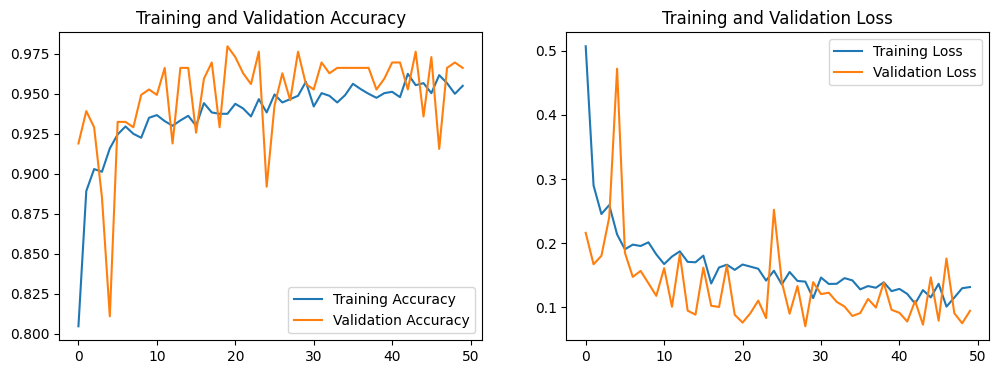

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 5s 5s/step
[0.0021757  0.9926966  0.00512771]
Max Value: 1
Predicted Label: Potato___Late_blight


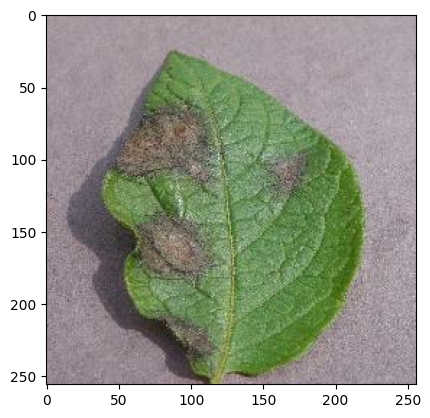

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


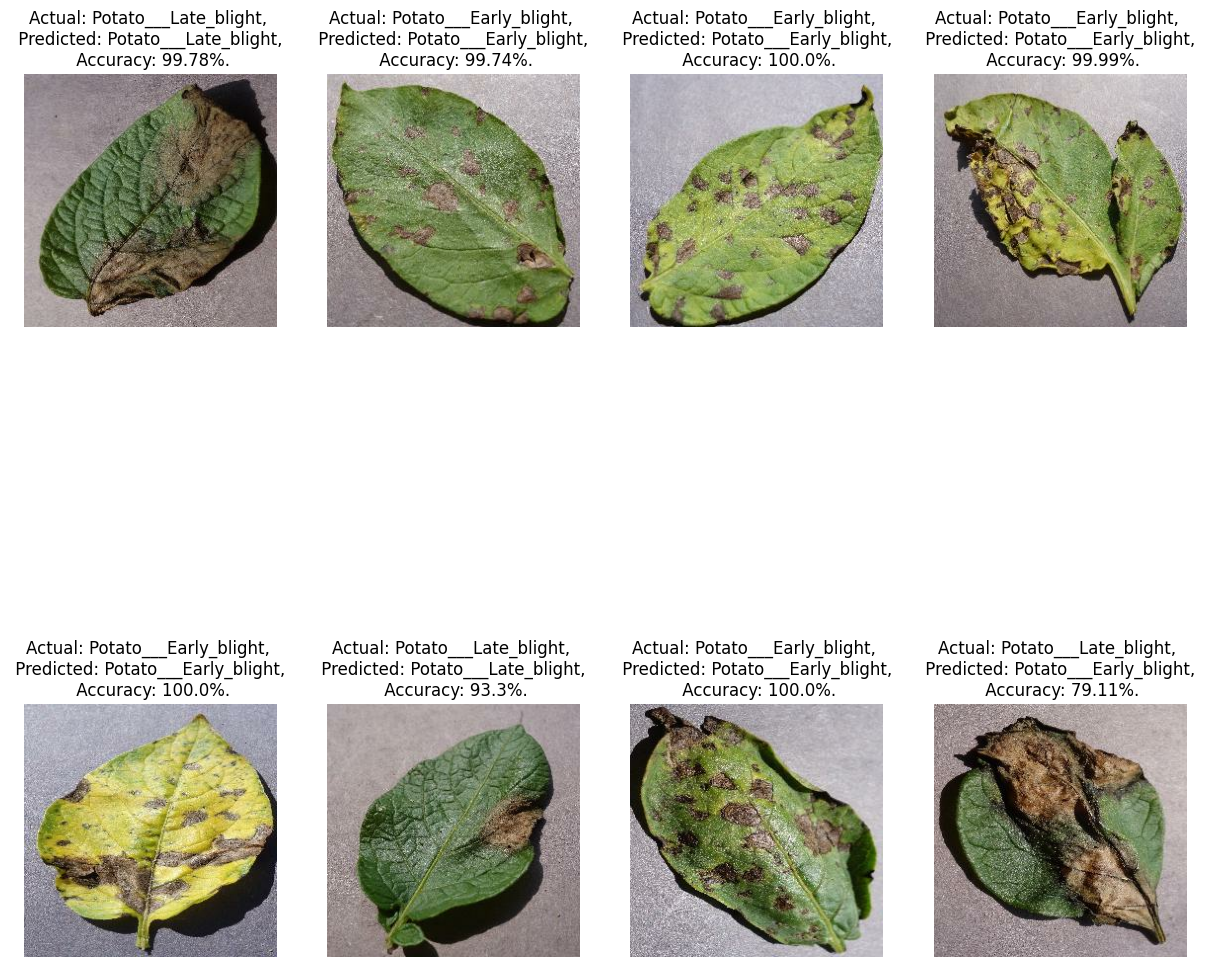

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  96.38158082962036


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 5s 84ms/step
F1 Score:  38.16570504005291
Precision Score:  38.213028003901414
Recall Score:  38.15789473684211


38/38 [==============================] - 3s 83ms/step


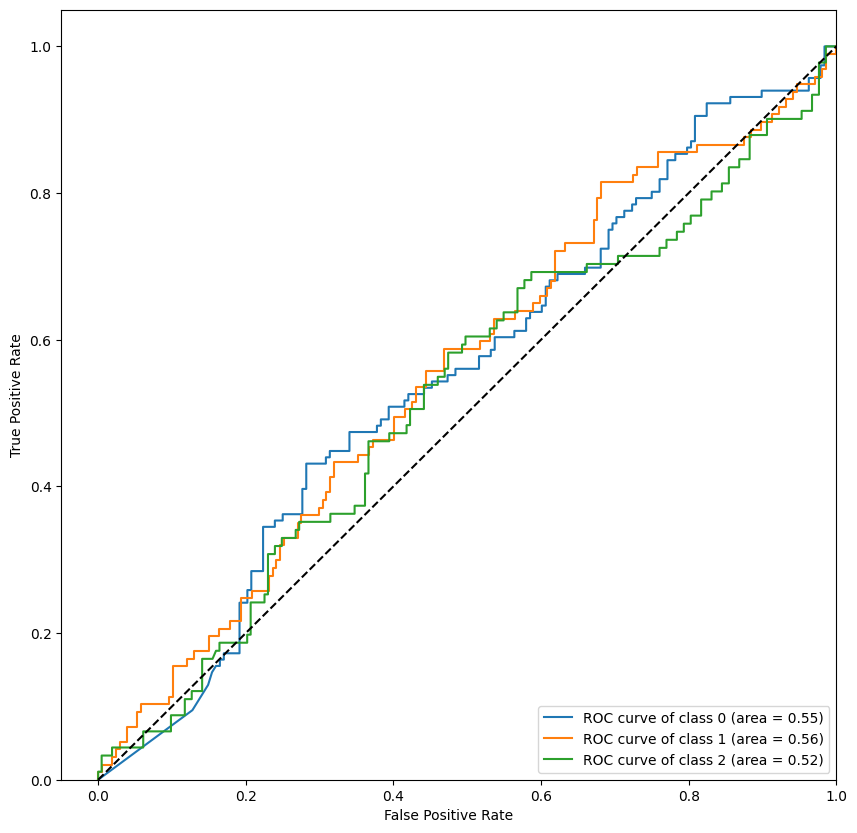

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 3s 82ms/step


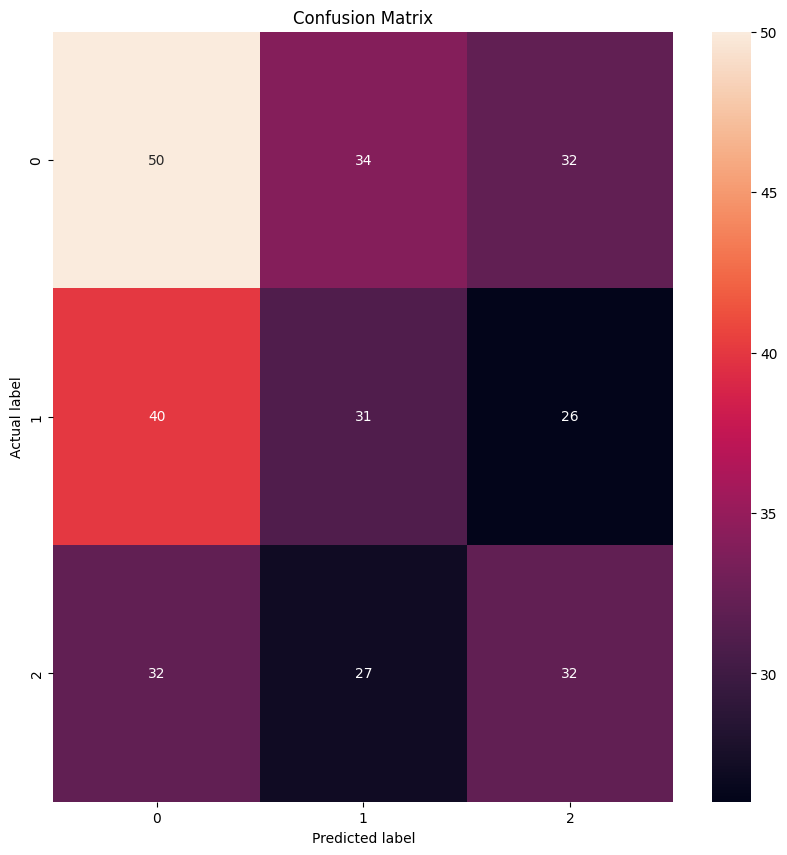

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()